In [132]:
# Import dependencies for file concatenation
import pandas as pd
import numpy as np
from scipy.io import loadmat
import os
import glob
from pathlib import Path
import warnings
import h5py
warnings.filterwarnings('ignore')

# Inspect the specific MAT file
dFF_file_path = r"E:\Neuropixels\TDT\1818\250918\1818_250918_dFF.mat"
RAW_file_path = r"E:\Neuropixels\TDT\1818\250918\Session_Mouse-250918-170624_UnivRAW_offdemod.mat"
csv1_file_path = r"E:\Neuropixels\Event\1818\Day12_1818_Clockwise_corner_2025-09-18T17_07_59.csv"
csv2_file_path = r"E:\Neuropixels\Event\1818\Day12_1818_Clockwise_licking_2025-09-18T17_07_59.csv"

RAW = h5py.File(RAW_file_path, 'r')

strobe_timing = RAW['handles']['Tr_1_on'][0]
lick_timing = RAW['handles']['Tr_2_on'][0]
reward_timing = RAW['handles']['Op_2_on'][0]
print("Strobe length:", len(strobe_timing))
print("Lick number:", len(lick_timing))
print("Reward number:",len(reward_timing))

# Load RAW stage1 timestamps (absolute seconds, downsampled Fs)
box = 0  # 0 = box1, 1 = box2, etc.

with h5py.File(RAW_file_path, 'r') as f_raw:
    ts_refs = f_raw['/handles/Ts']            # cell array of references
    ts_abs = np.array(f_raw[np.ravel(ts_refs)[box]]).squeeze()
    max_time = ts_abs.max()                   # used to undo normalization in dFF

# Load dFF and grab pair 1 (465/405)
mat_data = loadmat(dFF_file_path, squeeze_me=True, struct_as_record=False)

if 'dFFOut' in mat_data:                      # stage2 file with all boxes
    dff_struct = mat_data['dFFOut'].box[box].pair[0]
elif 'dFF' in mat_data:                       # per-box dFF file
    dff_struct = mat_data['dFF'].pair[0]
else:
    raise KeyError("No dFF/dFFOut found in MAT file")

dff_vals = np.array(dff_struct.data).squeeze()
dff_ts_norm = np.array(dff_struct.Ts).squeeze()

# Convert normalized time (0–1) back to seconds
dff_time_sec = ts_abs

print("dFF length:", len(dff_vals))
print("dFF time length:", len(dff_time_sec))

Strobe length: 200008
Lick number: 2143
Reward number: 104
dFF length: 1051418
dFF time length: 1051418


In [133]:
mat_data['dFF'].pair[2].data

array([0.02161859, 0.02164423, 0.02166977, ..., 1.63778201, 1.63992888,
       1.64187495])

🎯 CREATING REWARD-ALIGNED dFF PLOT
Sampling rate: 300.00 Hz
Number of rewards: 104
Window: -2s to +5s
Samples: -600 to +1500
Valid reward trials: 104
Valid reward trials: 104


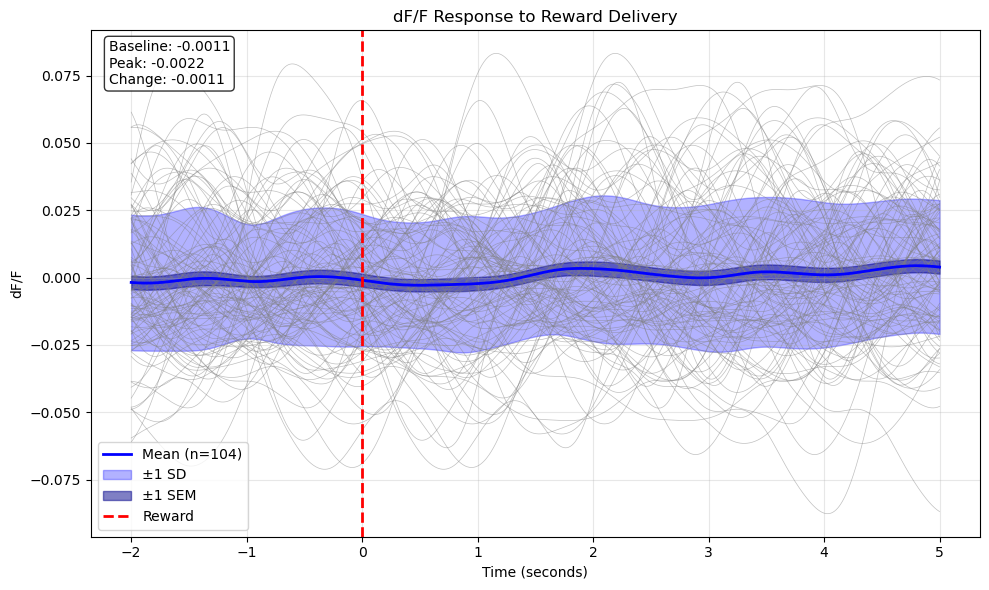


📊 SUMMARY STATISTICS:
Baseline dF/F (first 0.25s): -0.001119 ± 0.025094
Peak dF/F (0-0.5s post-reward): -0.002200 ± 0.023576
Change from baseline: -0.001082

📋 Individual Trial Summary:
   reward_time  baseline_dff  peak_dff  response_magnitude
0    52.722729      0.016026 -0.016174           -0.032200
1   105.879306     -0.021019 -0.003262            0.017756
2   106.909368      0.022568 -0.008459           -0.031027
3   114.882642      0.028739  0.028476           -0.000262
4   115.912540      0.039896 -0.008294           -0.048190


In [138]:
# PERI-EVENT TIME HISTOGRAM: dFF ALIGNED TO REWARD TIMING
import matplotlib.pyplot as plt

print("🎯 CREATING REWARD-ALIGNED dFF PLOT")
print("=" * 50)

# Parameters for the analysis
pre_time = 2   # seconds before reward
post_time = 5  # seconds after reward
sampling_rate = len(dff_vals) / dff_time_sec[-1]  # Calculate actual sampling rate

print(f"Sampling rate: {sampling_rate:.2f} Hz")
print(f"Number of rewards: {len(reward_timing)}")

# Convert time window to samples
pre_samples = int(pre_time * sampling_rate)
post_samples = int(post_time * sampling_rate)
total_samples = pre_samples + post_samples + 1

print(f"Window: -{pre_time}s to +{post_time}s")
print(f"Samples: -{pre_samples} to +{post_samples}")

# Create time vector for the plot
time_vector = np.linspace(-pre_time, post_time, total_samples)

# Extract dFF traces around each reward
reward_traces = []
valid_rewards = []

for i, reward_time in enumerate(reward_timing):
    # Find the closest sample index for this reward time
    reward_idx = np.argmin(np.abs(dff_time_sec - reward_time))
    
    # Check if we have enough data before and after
    start_idx = reward_idx - pre_samples
    end_idx = reward_idx + post_samples + 1
    
    if start_idx >= 0 and end_idx <= len(dff_vals):
        trace = dff_vals[start_idx:end_idx]
        if len(trace) == total_samples:  # Ensure consistent length
            reward_traces.append(trace)
            valid_rewards.append(reward_time)

reward_traces = np.array(reward_traces)
print(f"Valid reward trials: {len(reward_traces)}")

if len(reward_traces) > 0:
    # Calculate mean and standard deviation
    mean_trace = np.mean(reward_traces, axis=0)
    std_trace = np.std(reward_traces, axis=0)
    sem_trace = std_trace / np.sqrt(len(reward_traces))  # Standard error of mean
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot individual traces (lightly)
    for trace in reward_traces:
        plt.plot(time_vector, trace, alpha=0.5, color='gray', linewidth=0.5)
    
    # Plot mean trace
    plt.plot(time_vector, mean_trace, 'b-', linewidth=2, label=f'Mean (n={len(reward_traces)})')
    
    # Add shading for ±1 SD
    plt.fill_between(time_vector, 
                     mean_trace - std_trace, 
                     mean_trace + std_trace, 
                     alpha=0.3, color='blue', label='±1 SD')
    
    # Add shading for ±1 SEM (optional, often more informative)
    plt.fill_between(time_vector, 
                     mean_trace - sem_trace, 
                     mean_trace + sem_trace, 
                     alpha=0.5, color='darkblue', label='±1 SEM')
    
    # Add vertical line at reward delivery
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Reward')
    
    # Formatting
    plt.xlabel('Time (seconds)')
    plt.ylabel('dF/F')
    plt.title('dF/F Response to Reward Delivery')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add statistics
    baseline_mean = np.mean(mean_trace[:pre_samples//2])  # First quarter as baseline
    peak_mean = np.mean(mean_trace[pre_samples:pre_samples+int(0.5*sampling_rate)])  # First 0.5s after reward
    
    plt.text(0.02, 0.98, f'Baseline: {baseline_mean:.4f}\nPeak: {peak_mean:.4f}\nChange: {peak_mean-baseline_mean:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 SUMMARY STATISTICS:")
    print(f"Baseline dF/F (first 0.25s): {baseline_mean:.6f} ± {np.std(reward_traces[:, :pre_samples//2]):.6f}")
    print(f"Peak dF/F (0-0.5s post-reward): {peak_mean:.6f} ± {np.std(reward_traces[:, pre_samples:pre_samples+int(0.5*sampling_rate)]):.6f}")
    print(f"Change from baseline: {peak_mean - baseline_mean:.6f}")
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'reward_time': valid_rewards,
        'baseline_dff': [np.mean(trace[:pre_samples//2]) for trace in reward_traces],
        'peak_dff': [np.mean(trace[pre_samples:pre_samples+int(0.5*sampling_rate)]) for trace in reward_traces],
        'response_magnitude': [np.mean(trace[pre_samples:pre_samples+int(0.5*sampling_rate)]) - np.mean(trace[:pre_samples//2]) for trace in reward_traces]
    })
    
    print(f"\n📋 Individual Trial Summary:")
    print(summary_df.head())
    
    # Store results for later use
    reward_analysis = {
        'time_vector': time_vector,
        'mean_trace': mean_trace,
        'std_trace': std_trace,
        'sem_trace': sem_trace,
        'individual_traces': reward_traces,
        'valid_reward_times': valid_rewards,
        'summary_df': summary_df
    }
    
else:
    print("❌ No valid reward trials found!")
    print("Check that reward timing overlaps with dFF recording period")

👅 CREATING LICK-ALIGNED dFF PLOT
Sampling rate: 300.00 Hz
Number of licks: 2143
Window: -0.5s to +1.0s
Samples: -150 to +300
Valid lick trials: 2143
Valid lick trials: 2143


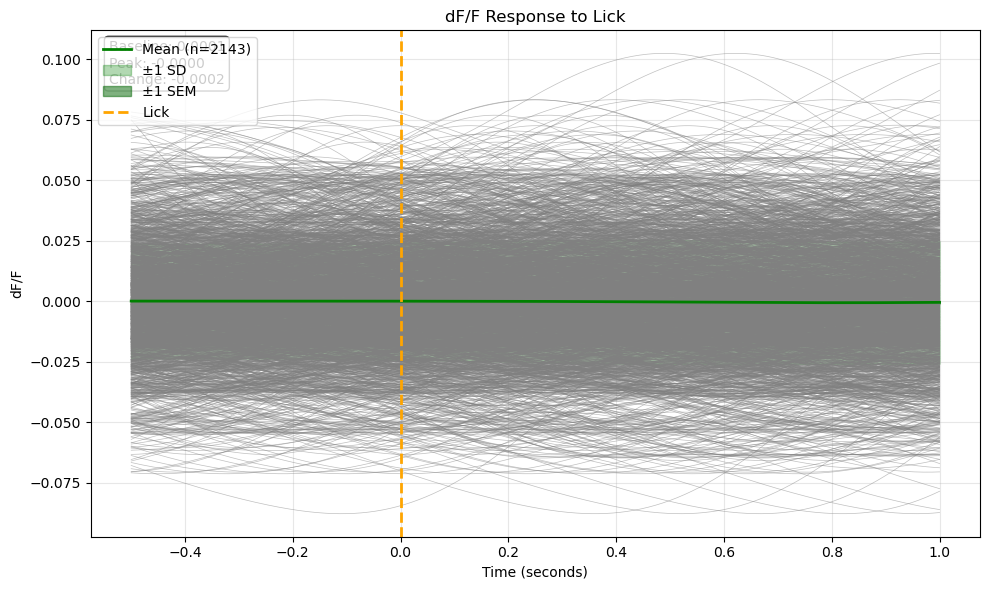


📊 SUMMARY STATISTICS:
Baseline dF/F (first 0.25s): 0.000112 ± 0.023670
Peak dF/F (0-0.5s post-lick): -0.000040 ± 0.025078
Change from baseline: -0.000152

📋 Individual Trial Summary:
   lick_time  baseline_dff  peak_dff  response_magnitude
0  24.297144     -0.016932 -0.009414            0.007517
1  52.691763     -0.005178 -0.014596           -0.009418
2  56.093082      0.003050  0.058659            0.055609
3  56.213340      0.019606  0.054489            0.034884
4  59.008778      0.000550 -0.018009           -0.018560


In [137]:
# PERI-EVENT TIME HISTOGRAM: dFF ALIGNED TO LICK TIMING
import matplotlib.pyplot as plt

print("👅 CREATING LICK-ALIGNED dFF PLOT")
print("=" * 50)

# Parameters for the analysis
pre_time = 0.5   # seconds before lick
post_time = 1.0  # seconds after lick
sampling_rate = len(dff_vals) / dff_time_sec[-1]  # Calculate actual sampling rate

print(f"Sampling rate: {sampling_rate:.2f} Hz")
print(f"Number of licks: {len(lick_timing)}")

# Convert time window to samples
pre_samples = int(pre_time * sampling_rate)
post_samples = int(post_time * sampling_rate)
total_samples = pre_samples + post_samples + 1

print(f"Window: -{pre_time}s to +{post_time}s")
print(f"Samples: -{pre_samples} to +{post_samples}")

# Create time vector for the plot
time_vector = np.linspace(-pre_time, post_time, total_samples)

# Extract dFF traces around each lick
lick_traces = []
valid_licks = []

for i, lick_time in enumerate(lick_timing):
    # Find the closest sample index for this lick time
    lick_idx = np.argmin(np.abs(dff_time_sec - lick_time))
    
    # Check if we have enough data before and after
    start_idx = lick_idx - pre_samples
    end_idx = lick_idx + post_samples + 1
    
    if start_idx >= 0 and end_idx <= len(dff_vals):
        trace = dff_vals[start_idx:end_idx]
        if len(trace) == total_samples:  # Ensure consistent length
            lick_traces.append(trace)
            valid_licks.append(lick_time)

lick_traces = np.array(lick_traces)
print(f"Valid lick trials: {len(lick_traces)}")

if len(lick_traces) > 0:
    # Calculate mean and standard deviation
    mean_trace = np.mean(lick_traces, axis=0)
    std_trace = np.std(lick_traces, axis=0)
    sem_trace = std_trace / np.sqrt(len(lick_traces))  # Standard error of mean
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot individual traces (lightly)
    for trace in lick_traces:
        plt.plot(time_vector, trace, alpha=0.5, color='gray', linewidth=0.5)
    
    # Plot mean trace
    plt.plot(time_vector, mean_trace, 'g-', linewidth=2, label=f'Mean (n={len(lick_traces)})')
    
    # Add shading for ±1 SD
    plt.fill_between(time_vector, 
                     mean_trace - std_trace, 
                     mean_trace + std_trace, 
                     alpha=0.3, color='green', label='±1 SD')
    
    # Add shading for ±1 SEM (optional, often more informative)
    plt.fill_between(time_vector, 
                     mean_trace - sem_trace, 
                     mean_trace + sem_trace, 
                     alpha=0.5, color='darkgreen', label='±1 SEM')
    
    # Add vertical line at lick timing
    plt.axvline(x=0, color='orange', linestyle='--', linewidth=2, label='Lick')
    
    # Formatting
    plt.xlabel('Time (seconds)')
    plt.ylabel('dF/F')
    plt.title('dF/F Response to Lick')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add statistics
    baseline_mean = np.mean(mean_trace[:pre_samples//2])  # First quarter as baseline
    peak_mean = np.mean(mean_trace[pre_samples:pre_samples+int(0.5*sampling_rate)])  # First 0.5s after lick
    
    plt.text(0.02, 0.98, f'Baseline: {baseline_mean:.4f}\nPeak: {peak_mean:.4f}\nChange: {peak_mean-baseline_mean:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 SUMMARY STATISTICS:")
    print(f"Baseline dF/F (first 0.25s): {baseline_mean:.6f} ± {np.std(lick_traces[:, :pre_samples//2]):.6f}")
    print(f"Peak dF/F (0-0.5s post-lick): {peak_mean:.6f} ± {np.std(lick_traces[:, pre_samples:pre_samples+int(0.5*sampling_rate)]):.6f}")
    print(f"Change from baseline: {peak_mean - baseline_mean:.6f}")
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'lick_time': valid_licks,
        'baseline_dff': [np.mean(trace[:pre_samples//2]) for trace in lick_traces],
        'peak_dff': [np.mean(trace[pre_samples:pre_samples+int(0.5*sampling_rate)]) for trace in lick_traces],
        'response_magnitude': [np.mean(trace[pre_samples:pre_samples+int(0.5*sampling_rate)]) - np.mean(trace[:pre_samples//2]) for trace in lick_traces]
    })
    
    print(f"\n📋 Individual Trial Summary:")
    print(summary_df.head())
    
    # Store results for later use
    lick_analysis = {
        'time_vector': time_vector,
        'mean_trace': mean_trace,
        'std_trace': std_trace,
        'sem_trace': sem_trace,
        'individual_traces': lick_traces,
        'valid_lick_times': valid_licks,
        'summary_df': summary_df
    }
    
else:
    print("❌ No valid lick trials found!")
    print("Check that lick timing overlaps with dFF recording period")